# CORPUS-INFORMED AUTO-TRANSLATOR: VECTOR CREATION NOTEBOOK
Day 3: Converting JSON Document into Semantic Vectors
(Creating vectors from a single corpus item)

## Notebook Outline

**Part 1: Data Preparation and Planning**

- STEP 1: LOAD THE REQUIRED LIBRARIES
- STEP 2: LOAD AND EXAMINE DATABASE STRUCTURE
- STEP 3: LOAD AND EXAMINE INDIVIDUAL CORPUS ITEM

**Part 2: Function and Model Setup**

- STEP 4: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL (WITH DEMONSTRATION)
- STEP 5: PREPARE THE VECTOR STORAGE STRUCTURE (SCHEMA COMPLIANT)
- STEP 6: DEFINE TEXT EXTRACTION FUNCTIONS
- STEP 7: CREATE VECTORIZATION FUNCTIONS

**Part 3: Execution and Output**
- STEP 8: BATCH PROCESS DOCUMENTS
- STEP 9: VISUALIZE THE VECTORS

## =============================================================================

## Part 1: Data Preparation and Planning

### STEP 1: LOAD THE REQUIRED LIBRARIES

In [ ]:
### STEP 1: LOAD THE REQUIRED LIBRARIES

# Core Python libraries
import json
import os
from pathlib import Path
import logging
from typing import Dict, List, Tuple, Optional
from datetime import datetime

# Data processing libraries
import pandas as pd
import numpy as np

# Text processing libraries
import re
from collections import defaultdict

# Machine learning and embedding libraries
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Progress tracking (helpful for long processing times)
from tqdm.notebook import tqdm

# Visualization libraries (for testing our vectors)
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration management
import sys
sys.path.append('../scripts')  # Add scripts folder to path
from config import *  # Import all our configuration settings

# Set up logging for debugging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ All libraries loaded successfully!")
print(f"📁 Working with domain: {DOMAIN}")
print(f"🌐 Processing languages: {LANGUAGES}")
print(f"🤖 Using model: {MODEL_NAME}")

✅ All libraries loaded successfully!
📁 Working with domain: gai
🌐 Processing languages: ['eng', 'esp']
🤖 Using model: paraphrase-multilingual-MiniLM-L12-v2


### STEP 2: LOAD AND EXAMINE DATABASE STRUCTURE

In [ ]:
### STEP 2: LOAD AND EXAMINE DATABASE STRUCTURE

def load_database_file(language):
    """Load the database file for a specific language"""
    database_path = Path(CORPORA_DIR) / language / f"{DOMAIN}-{language}_database.json"
    
    if not database_path.exists():
        raise FileNotFoundError(f"Database file not found: {database_path}")
    
    with open(database_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# Load databases for all languages
databases = {}
all_documents = {}  # Store all documents for easy access

for language in LANGUAGES:
    try:
        print(f"🔍 Loading {language.upper()} database...")
        databases[language] = load_database_file(language)
        
        # Show database structure
        db = databases[language]
        print(f"📊 {language.upper()} database contains {len(db)} top-level keys:")
        for key in list(db.keys())[:5]:  # Show first 5 keys
            print(f"  • {key}")
        
        # Count actual documents (excluding template)
        # Handle mixed structure: check both nested 'documents' and top-level keys
        documents = {}
        
        # First, get documents from nested 'documents' key
        if 'documents' in db and isinstance(db['documents'], dict):
            nested_docs = {k: v for k, v in db['documents'].items() if k.startswith(f'gai-{language}_item')}
            documents.update(nested_docs)
        
        # Also check for direct top-level document keys
        top_level_docs = {k: v for k, v in db.items() if k != 'gai_template' and k != 'documents' and k.startswith(f'gai-{language}_item')}
        documents.update(top_level_docs)
        
        # Store documents for this language
        all_documents[language] = documents
        
        print(f"📚 Found {len(documents)} documents in {language.upper()} database")
        
        # Show ALL document IDs (not just sample)
        if documents:
            print(f"  All document IDs:")
            for i, (doc_id, doc_data) in enumerate(documents.items(), 1):
                title = doc_data.get('document_metadata', {}).get('title', 'No title')
                print(f"    {i:2d}. {doc_id}: {title[:60]}{'...' if len(title) > 60 else ''}")
        
        print()  # Add blank line between languages
        
    except FileNotFoundError as e:
        print(f"❌ Error loading {language.upper()} database: {e}")
        print(f"Expected location: {Path(CORPORA_DIR) / language / f'{DOMAIN}-{language}_database.json'}")
        print()

print(f"✅ Successfully loaded databases for: {', '.join(databases.keys())}")

# Calculate correct total documents using the stored documents
total_documents = sum(len(docs) for docs in all_documents.values())
print(f"📊 Total documents across all languages: {total_documents}")

# Show breakdown by language
print(f"\n📊 Document count breakdown:")
for language, docs in all_documents.items():
    print(f"  • {language.upper()}: {len(docs)} documents")

# Show expected file locations for all languages
print(f"\n📂 Expected database file locations:")
for language in LANGUAGES:
    expected_path = Path(CORPORA_DIR) / language / f"{DOMAIN}-{language}_database.json"
    print(f"  • {language.upper()}: {expected_path}")

# Optional: Create a summary dictionary for easy access
document_summary = {
    'total_count': total_documents,
    'by_language': {lang: len(docs) for lang, docs in all_documents.items()},
    'all_documents': all_documents
}

print(f"\n📋 Summary:")
print(f"Total documents loaded: {document_summary['total_count']}")
for lang, count in document_summary['by_language'].items():
    print(f"  {lang.upper()}: {count} documents")

🔍 Loading ENG database...
📊 ENG database contains 1 top-level keys:
  • documents
📚 Found 4 documents in ENG database
  All document IDs:
     1. gai-eng_item001: Attention is All You Need
     2. gai-eng_item002: On the Dangers of Stochastic Parrots: Can Language Models Be...
     3. gai-eng_item003: Recommendation on the Ethics of Artificial Intelligence
     4. gai-eng_item004: The Age of AI has begun

🔍 Loading ESP database...
📊 ESP database contains 1 top-level keys:
  • documents
📚 Found 2 documents in ESP database
  All document IDs:
     1. gai-esp_item001: Propuesta de Agenda Nacional de la Inteligencia Artificial p...
     2. gai-esp_item002: Conversando con una computadora: ¿Cómo entienden las intelig...

✅ Successfully loaded databases for: eng, esp
📊 Total documents across all languages: 6

📊 Document count breakdown:
  • ENG: 4 documents
  • ESP: 2 documents

📂 Expected database file locations:
  • ENG: ..\corpora\gai\eng\gai-eng_database.json
  • ESP: ..\corpora\gai\esp\

### STEP 3: LOAD AND EXAMINE INDIVIDUAL CORPUS ITEM

In [ ]:
### STEP 3: LOAD AND EXAMINE INDIVIDUAL CORPUS ITEM

def load_corpus_item(language, item_id):
    """Load a specific corpus item JSON file (content only)"""
    item_path = Path(CORPORA_DIR) / language / "processed" / f"{item_id}.json"
    
    if not item_path.exists():
        raise FileNotFoundError(f"Corpus item not found: {item_path}")
    
    with open(item_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def get_document_metadata(databases, language, item_id):
    """Get metadata for a document from the database"""
    db = databases.get(language, {})
    documents = db.get('documents', {})
    return documents.get(item_id, {})

def merge_content_and_metadata(content_data, metadata):
    """Merge content and metadata into a complete document object"""
    return {
        'document_id': content_data.get('document_id'),
        'document_metadata': metadata.get('document_metadata', {}),
        'processing_metadata': metadata.get('processing_metadata', {}),
        'content': content_data.get('content', {})
    }

def analyze_corpus_structure(corpus_item):
    """
    Enhanced analysis that provides complete hierarchical breakdown
    """
    analysis = {
        'document_id': corpus_item.get('document_id', 'Unknown'),
        'title': corpus_item.get('document_metadata', {}).get('title', 'No title'),
        'language': corpus_item.get('document_metadata', {}).get('language_variant', 'Unknown'),
        'text_type': corpus_item.get('document_metadata', {}).get('text_type', 'Unknown'),
        'word_count': corpus_item.get('processing_metadata', {}).get('word_count', 0),
        'has_abstract': bool(corpus_item.get('content', {}).get('abstract')),
        'abstract_length': len(corpus_item.get('content', {}).get('abstract', '')),
        'sections': [],
        'total_paragraphs': 0,
        'total_subsections': 0,
        'total_subsubsections': 0,
        'total_text_length': 0
    }
    
    # Analyze sections and paragraphs
    content = corpus_item.get('content', {})
    sections = content.get('sections', [])
    
    for section in sections:
        section_info = {
            'id': section.get('id', 'No ID'),
            'title': section.get('title', 'No title'),
            'main_paragraph_count': len(section.get('paragraphs', [])),
            'subsection_count': len(section.get('subsections', [])),
            'subsubsection_count': 0,
            'total_section_paragraphs': 0,  # All paragraphs in this section
            'text_length': 0,
            'subsections': []
        }
        
        # Count main section paragraphs
        section_info['total_section_paragraphs'] += section_info['main_paragraph_count']
        analysis['total_paragraphs'] += section_info['main_paragraph_count']
        
        # Calculate text length for main section
        for paragraph in section.get('paragraphs', []):
            paragraph_text = paragraph.get('text', '')
            section_info['text_length'] += len(paragraph_text)
        
        # Process subsections
        for subsection in section.get('subsections', []):
            subsection_info = {
                'id': subsection.get('id', 'No ID'),
                'title': subsection.get('title', 'No title'),
                'paragraph_count': len(subsection.get('paragraphs', [])),
                'subsubsection_count': 0,  # Initialize counter for this subsection
                'subsubsections': []
            }
            
            # Count subsection paragraphs
            section_info['total_section_paragraphs'] += subsection_info['paragraph_count']
            analysis['total_paragraphs'] += subsection_info['paragraph_count']
            
            # Add subsection text length
            for paragraph in subsection.get('paragraphs', []):
                paragraph_text = paragraph.get('text', '')
                section_info['text_length'] += len(paragraph_text)
            
            # Process subsubsections - FIXED: Check for 'subsubsections' key
            subsubsections = subsection.get('subsubsections', [])
            if subsubsections:
                for subsubsection in subsubsections:
                    subsubsection_info = {
                        'id': subsubsection.get('id', 'No ID'),
                        'title': subsubsection.get('title', 'No title'),
                        'paragraph_count': len(subsubsection.get('paragraphs', []))
                    }
                    
                    # Count subsubsection paragraphs
                    section_info['total_section_paragraphs'] += subsubsection_info['paragraph_count']
                    analysis['total_paragraphs'] += subsubsection_info['paragraph_count']
                    subsection_info['subsubsection_count'] += 1
                    section_info['subsubsection_count'] += 1
                    
                    # Add subsubsection text
                    for paragraph in subsubsection.get('paragraphs', []):
                        paragraph_text = paragraph.get('text', '')
                        section_info['text_length'] += len(paragraph_text)
                    
                    subsection_info['subsubsections'].append(subsubsection_info)
            
            section_info['subsections'].append(subsection_info)
        
        analysis['sections'].append(section_info)
        analysis['total_subsections'] += section_info['subsection_count']
        analysis['total_subsubsections'] += section_info['subsubsection_count']
        analysis['total_text_length'] += section_info['text_length']
    
    # Add abstract to total text length
    analysis['total_text_length'] += analysis['abstract_length']
    
    return analysis

def display_enhanced_analysis(analysis):
    """Display the enhanced analysis with complete hierarchy"""
    
    print(f"\n📊 DOCUMENT ANALYSIS:")
    print(f"  🔖 ID: {analysis['document_id']}")
    print(f"  📝 Title: {analysis['title']}")
    print(f"  🌐 Language: {analysis['language']}")
    print(f"  📄 Type: {analysis['text_type']}")
    print(f"  📏 Word Count: {analysis['word_count']:,}")
    print(f"  📝 Total Text Length: {analysis['total_text_length']:,} characters")
    
    print(f"\n📋 STRUCTURE FOR VECTORIZATION:")
    print(f"  🔍 Abstract: {'Yes' if analysis['has_abstract'] else 'No'} ({analysis['abstract_length']:,} chars)")
    print(f"  📚 Main Sections: {len(analysis['sections'])}")
    print(f"  📂 Total Subsections: {analysis['total_subsections']}")
    print(f"  🔗 Total Sub-subsections: {analysis['total_subsubsections']}")
    print(f"  📝 Total Paragraphs: {analysis['total_paragraphs']}")
    
    print(f"\n📑 DETAILED SECTION BREAKDOWN:")
    for i, section in enumerate(analysis['sections'], 1):
        print(f"  {i:2d}. {section['title']}")
        
        # Show structure summary first
        structure_parts = []
        if section['main_paragraph_count'] > 0:
            structure_parts.append(f"{section['main_paragraph_count']} main paragraphs")
        if section['subsection_count'] > 0:
            structure_parts.append(f"{section['subsection_count']} subsections")
        if section['subsubsection_count'] > 0:
            structure_parts.append(f"{section['subsubsection_count']} sub-subsections")
        
        print(f"      📊 Structure: {', '.join(structure_parts)}")
        print(f"      📝 Total paragraphs in section: {section['total_section_paragraphs']}")
        print(f"      📏 {section['text_length']:,} characters")
        
        # Show subsection details if any
        if section['subsections']:
            print(f"      📂 Subsection breakdown:")
            for j, subsection in enumerate(section['subsections'], 1):
                subsection_id = subsection['id'].split('_')[-1] if '_' in subsection['id'] else f"{i}.{j}"
                print(f"        {subsection_id} {subsection['title']}: {subsection['paragraph_count']} paragraphs")
                
                # Show sub-subsections if any - FIXED: Now properly displays subsubsections
                if subsection['subsubsections']:
                    for k, subsubsection in enumerate(subsection['subsubsections'], 1):
                        subsubsection_id = subsubsection['id'].split('_')[-1] if '_' in subsubsection['id'] else f"{i}.{j}.{k}"
                        print(f"          {subsubsection_id} {subsubsection['title']}: {subsubsection['paragraph_count']} paragraphs")
        print()  # Empty line between sections
    
    print(f"🎯 VECTORIZATION PLAN:")
    structural_vectors = 1 + len(analysis['sections']) + analysis['total_subsections'] + analysis['total_subsubsections']
    total_vectors = structural_vectors + analysis['total_paragraphs']
    
    print(f"  • Document-level vectors: 1")
    print(f"  • Section-level vectors: {len(analysis['sections'])}")
    print(f"  • Subsection-level vectors: {analysis['total_subsections']}")
    print(f"  • Sub-subsection-level vectors: {analysis['total_subsubsections']}")
    print(f"  • Paragraph-level vectors: {analysis['total_paragraphs']}")
    print(f"  • Total vectors to create: {total_vectors}")

# Load and analyze our test document
test_doc_id = "gai-eng_item001" 
test_language = "eng"

print(f"📖 Loading and analyzing corpus item: {test_doc_id}")

try:
    # Load content from corpus item file
    content_data = load_corpus_item(test_language, test_doc_id)
    print(f"✅ Loaded content from corpus item file")
    
    # Get metadata from database
    if test_language in databases:
        metadata = get_document_metadata(databases, test_language, test_doc_id)
        print(f"✅ Retrieved metadata from database")
        
        # Merge content and metadata
        corpus_item = merge_content_and_metadata(content_data, metadata)
        
        # Analyze the merged document
        analysis = analyze_corpus_structure(corpus_item)
        
        # Display enhanced analysis
        display_enhanced_analysis(analysis)
        
    else:
        print(f"❌ Database for {test_language} not loaded")
    
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print(f"💡 Make sure you have placed {test_doc_id}.json in:")
    print(f"   {Path(CORPORA_DIR) / test_language / 'processed' / f'{test_doc_id}.json'}")
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    print("💡 Check that the JSON file structure matches the expected format")

print(f"\n📂 Expected file locations:")
print(f"  📊 Metadata: {Path(CORPORA_DIR) / test_language / f'{DOMAIN}-{test_language}_database.json'}")
print(f"  📄 Content: {Path(CORPORA_DIR) / test_language / 'processed' / f'{test_doc_id}.json'}")

📖 Loading and analyzing corpus item: gai-eng_item001
✅ Loaded content from corpus item file
✅ Retrieved metadata from database

📊 DOCUMENT ANALYSIS:
  🔖 ID: gai-eng_item001
  📝 Title: Attention is All You Need
  🌐 Language: usa
  📄 Type: Academic paper
  📏 Word Count: 5,817
  📝 Total Text Length: 24,391 characters

📋 STRUCTURE FOR VECTORIZATION:
  🔍 Abstract: Yes (1,139 chars)
  📚 Main Sections: 7
  📂 Total Subsections: 12
  🔗 Total Sub-subsections: 3
  📝 Total Paragraphs: 69

📑 DETAILED SECTION BREAKDOWN:
   1. Introduction
      📊 Structure: 4 main paragraphs
      📝 Total paragraphs in section: 4
      📏 1,900 characters

   2. Background
      📊 Structure: 4 main paragraphs
      📝 Total paragraphs in section: 4
      📏 1,810 characters

   3. Model Architecture
      📊 Structure: 2 main paragraphs, 5 subsections, 3 sub-subsections
      📝 Total paragraphs in section: 29
      📏 8,642 characters
      📂 Subsection breakdown:
        1 Encoder and Decoder Stacks: 2 paragraphs
      

## =============================================================================

## Part 2: Function and Model Setup

### STEP 4: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL

In [ ]:
### STEP 4: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL

# Initialize the multilingual sentence transformer model
print("🤖 Loading multilingual embedding model...")
print("This may take a moment on first run as it downloads the model (~420MB)")

try:
    # Load the model that creates our unified vector space
    model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    print("✅ Model loaded successfully!")
    
    # Display model information
    print(f"\n📊 Model Information:")
    print(f"  • Model name: {model._modules['0'].auto_model.config._name_or_path}")
    print(f"  • Embedding dimension: {model.get_sentence_embedding_dimension()}")
    print(f"  • Max sequence length: {model.max_seq_length}")
    print(f"  • Supports 50+ languages including English and Spanish")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("💡 Try running: pip install sentence-transformers")

2025-05-28 23:53:08,887 - INFO - Use pytorch device_name: cpu
2025-05-28 23:53:08,888 - INFO - Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2


🤖 Loading multilingual embedding model...
This may take a moment on first run as it downloads the model (~420MB)
✅ Model loaded successfully!

📊 Model Information:
  • Model name: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
  • Embedding dimension: 384
  • Max sequence length: 128
  • Supports 50+ languages including English and Spanish


#### DEMONSTRATION: UNIFIED VECTOR SPACE FOR BILINGUAL CONTENT

In [ ]:
# Demonstrate the unified vector space with a simple multilingual example
print("\n🌐 DEMONSTRATING UNIFIED VECTOR SPACE:")
print("=" * 60)

# Test sentences in English and Spanish
test_sentences = [
    "Artificial intelligence is transforming our world",  # English
    "La inteligencia artificial está transformando nuestro mundo",  # Spanish (same meaning)
    "Machine learning requires large amounts of data",  # English
    "El aprendizaje automático requiere grandes cantidades de datos",  # Spanish (same meaning)
    "The weather is nice today",  # English (unrelated)
    "El clima está agradable hoy"  # Spanish (unrelated)
]

# Create embeddings
print("Creating embeddings for test sentences...")
test_embeddings = model.encode(test_sentences)

# Calculate similarity between English and Spanish pairs
from sklearn.metrics.pairwise import cosine_similarity

print("\n📈 Similarity scores (0-1, higher = more similar):")
print("-" * 60)

# Compare sentence pairs
for i in range(0, len(test_sentences), 2):
    eng_sentence = test_sentences[i]
    spa_sentence = test_sentences[i+1]
    
    similarity = cosine_similarity(
        test_embeddings[i].reshape(1, -1),
        test_embeddings[i+1].reshape(1, -1)
    )[0][0]
    
    print(f"\nEnglish: '{eng_sentence[:40]}...'")
    print(f"Spanish: '{spa_sentence[:40]}...'")
    print(f"Similarity: {similarity:.4f} {'✅ High similarity!' if similarity > 0.8 else ''}")

# Show that unrelated sentences have lower similarity
print("\n🔍 Cross-language comparison (unrelated sentences):")
unrelated_sim = cosine_similarity(
    test_embeddings[0].reshape(1, -1),  # AI sentence in English
    test_embeddings[4].reshape(1, -1)   # Weather sentence in English
)[0][0]
print(f"'Artificial intelligence...' vs 'The weather...': {unrelated_sim:.4f}")


🌐 DEMONSTRATING UNIFIED VECTOR SPACE:
Creating embeddings for test sentences...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


📈 Similarity scores (0-1, higher = more similar):
------------------------------------------------------------

English: 'Artificial intelligence is transforming ...'
Spanish: 'La inteligencia artificial está transfor...'
Similarity: 0.9880 ✅ High similarity!

English: 'Machine learning requires large amounts ...'
Spanish: 'El aprendizaje automático requiere grand...'
Similarity: 0.9280 ✅ High similarity!

English: 'The weather is nice today...'
Spanish: 'El clima está agradable hoy...'
Similarity: 0.9361 ✅ High similarity!

🔍 Cross-language comparison (unrelated sentences):
'Artificial intelligence...' vs 'The weather...': -0.0196



📊 VISUALIZING THE UNIFIED VECTOR SPACE:


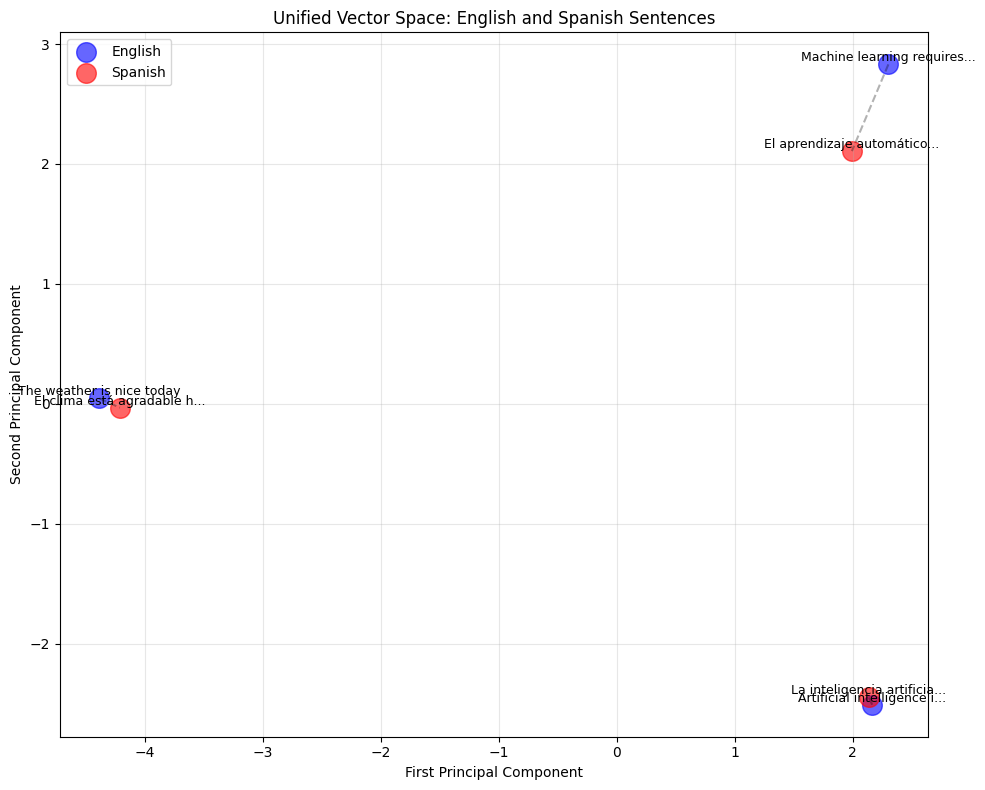


💡 Notice how translation pairs (connected by lines) are close together!
This demonstrates that our model creates a truly multilingual vector space.


In [ ]:
# Visualize the test embeddings in 2D space
print("\n📊 VISUALIZING THE UNIFIED VECTOR SPACE:")
print("=" * 60)

# Reduce dimensions for visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(test_embeddings)

# Create visualization
plt.figure(figsize=(10, 8))

# Plot English sentences
plt.scatter(embeddings_2d[::2, 0], embeddings_2d[::2, 1], 
           c='blue', s=200, alpha=0.6, label='English')

# Plot Spanish sentences
plt.scatter(embeddings_2d[1::2, 0], embeddings_2d[1::2, 1], 
           c='red', s=200, alpha=0.6, label='Spanish')

# Add labels
for i, txt in enumerate(test_sentences):
    # Shorten text for display
    display_text = txt[:25] + "..." if len(txt) > 25 else txt
    plt.annotate(display_text, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                fontsize=9, ha='center', va='bottom')

# Draw lines between translation pairs
for i in range(0, len(test_sentences), 2):
    plt.plot([embeddings_2d[i, 0], embeddings_2d[i+1, 0]], 
             [embeddings_2d[i, 1], embeddings_2d[i+1, 1]], 
             'k--', alpha=0.3)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Unified Vector Space: English and Spanish Sentences')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Notice how translation pairs (connected by lines) are close together!")
print("This demonstrates that our model creates a truly multilingual vector space.")

### STEP 5: PREPARE THE VECTOR STORAGE STRUCTURE (SCHEMA COMPLIANT)

Note: Consider adding "text_length" to vector structure in a future iteration

In [ ]:
### STEP 5: PREPARE THE VECTOR STORAGE STRUCTURE (SCHEMA COMPLIANT)

# Prepare vector storage structure
print("\n📦 PREPARING VECTOR STORAGE STRUCTURE:")
print("=" * 60)

print("✅ Using standardized schema for vector storage")
print("\n📋 Schema structure:")
print("  • metadata: Model name and embedding dimensions")
print("  • vectors: Array of vector objects with:")
print("    - Document vectors: id, title, count, created, vector, text")
print("    - Section vectors: id, document_id, title, level, count, created, vector, text")
print("    - Paragraph vectors: id, document_id, count, created, vector, text")

def save_document_vectors_json(vectors_data, filename, model):
    """Save document vectors to JSON file following the standardized schema"""
    
    vector_objects = []
    
    for i, vector_info in enumerate(vectors_data, 1):
        vector_obj = {
            "id": vector_info['id'],  # document_id
            "title": vector_info.get('title', 'No title'),
            "count": i,
            "created": datetime.now().isoformat(),
            "vector": vector_info['vector'].tolist() if hasattr(vector_info['vector'], 'tolist') else vector_info['vector'],
            "text": vector_info.get('text', '')[:500]  # Limit text length for storage
        }
        vector_objects.append(vector_obj)
    
    # Create the complete data structure following schema
    vector_data = {
        "metadata": {
            "model": "paraphrase-multilingual-MiniLM-L12-v2",
            "dimension": model.get_sentence_embedding_dimension()
        },
        "vectors": vector_objects
    }
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(vector_data, f, ensure_ascii=False, indent=2)
    
    print(f"💾 Saved {len(vector_objects)} document vectors to {filename}")

def save_section_vectors_json(vectors_data, filename, model):
    """Save section vectors to JSON file following the standardized schema"""
    
    vector_objects = []
    
    for i, vector_info in enumerate(vectors_data, 1):
        vector_obj = {
            "id": vector_info['id'],  # section_id
            "document_id": vector_info['document_id'],
            "title": vector_info.get('title', 'No title'),
            "level": vector_info.get('level', 0),
            "count": i,
            "created": datetime.now().isoformat(),
            "vector": vector_info['vector'].tolist() if hasattr(vector_info['vector'], 'tolist') else vector_info['vector'],
            "text": vector_info.get('text', '')[:500]  # Limit text length for storage
        }
        vector_objects.append(vector_obj)
    
    # Create the complete data structure following schema
    vector_data = {
        "metadata": {
            "model": "paraphrase-multilingual-MiniLM-L12-v2",
            "dimension": model.get_sentence_embedding_dimension()
        },
        "vectors": vector_objects
    }
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(vector_data, f, ensure_ascii=False, indent=2)
    
    print(f"💾 Saved {len(vector_objects)} section vectors to {filename}")

def save_paragraph_vectors_json(vectors_data, filename, model):
    """Save paragraph vectors to JSON file following the standardized schema"""
    
    vector_objects = []
    
    for i, vector_info in enumerate(vectors_data, 1):
        vector_obj = {
            "id": vector_info['id'],  # paragraph_id
            "document_id": vector_info['document_id'],
            "count": i,
            "created": datetime.now().isoformat(),
            "vector": vector_info['vector'].tolist() if hasattr(vector_info['vector'], 'tolist') else vector_info['vector'],
            "text": vector_info.get('text', '')[:300]  # Limit text length for storage
        }
        vector_objects.append(vector_obj)
    
    # Create the complete data structure following schema
    vector_data = {
        "metadata": {
            "model": "paraphrase-multilingual-MiniLM-L12-v2",
            "dimension": model.get_sentence_embedding_dimension()
        },
        "vectors": vector_objects
    }
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(vector_data, f, ensure_ascii=False, indent=2)
    
    print(f"💾 Saved {len(vector_objects)} paragraph vectors to {filename}")

def save_all_vectors_with_schema(vectors, extracted_content, model, output_dir):
    """
    Convenience function to save all vectors using the standardized schema format
    
    Args:
        vectors: Dictionary containing all vector data from create_vectors()
        extracted_content: Content data from extract_document_content()
        model: SentenceTransformer model
        output_dir: Directory to save vector files
    """
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    print("💾 SAVING VECTORS WITH STANDARDIZED SCHEMA:")
    print("=" * 60)
    
    # 1. Save document vectors
    document_vectors_data = [{
        'id': vectors['document_id'],
        'title': extracted_content['title'],
        'vector': vectors['document_vector']['vector'],
        'text': extracted_content['document_text']
    }]
    
    save_document_vectors_json(
        vectors_data=document_vectors_data,
        filename=os.path.join(output_dir, 'gai-document-vectors.json'),
        model=model
    )
    
    # 2. Save section vectors
    section_vectors_data = []
    for section_vec in vectors['section_vectors']:
        section_vectors_data.append({
            'id': section_vec['id'],
            'document_id': section_vec['document_id'],
            'title': section_vec['title'],
            'level': section_vec['level'],
            'vector': section_vec['vector'],
            'text': section_vec['text']
        })
    
    save_section_vectors_json(
        vectors_data=section_vectors_data,
        filename=os.path.join(output_dir, 'gai-section-vectors.json'),
        model=model
    )
    
    # 3. Save paragraph vectors
    paragraph_vectors_data = []
    for para_vec in vectors['paragraph_vectors']:
        paragraph_vectors_data.append({
            'id': para_vec['id'],
            'document_id': para_vec['document_id'],
            'vector': para_vec['vector'],
            'text': para_vec['text']
        })
    
    save_paragraph_vectors_json(
        vectors_data=paragraph_vectors_data,
        filename=os.path.join(output_dir, 'gai-paragraph-vectors.json'),
        model=model
    )
    
    print(f"\n✅ All vectors saved to: {output_dir}")
    print("Schema-compliant files created:")
    print("  • gai-document-vectors.json")
    print("  • gai-section-vectors.json") 
    print("  • gai-paragraph-vectors.json")

print("\n✅ Ready to create vectors from your corpus documents!")
print("📋 Available functions:")
print("  • save_document_vectors_json() - Save document-level vectors")
print("  • save_section_vectors_json() - Save section-level vectors") 
print("  • save_paragraph_vectors_json() - Save paragraph-level vectors")
print("  • save_all_vectors_with_schema() - Save all vector types at once")


📦 PREPARING VECTOR STORAGE STRUCTURE:
✅ Using standardized schema for vector storage

📋 Schema structure:
  • metadata: Model name and embedding dimensions
  • vectors: Array of vector objects with:
    - Document vectors: id, title, count, created, vector, text
    - Section vectors: id, document_id, title, level, count, created, vector, text
    - Paragraph vectors: id, document_id, count, created, vector, text

✅ Ready to create vectors from your corpus documents!
📋 Available functions:
  • save_document_vectors_json() - Save document-level vectors
  • save_section_vectors_json() - Save section-level vectors
  • save_paragraph_vectors_json() - Save paragraph-level vectors
  • save_all_vectors_with_schema() - Save all vector types at once


### STEP 6: DEFINE TEXT EXTRACTION FUNCTIONS

In [ ]:
### STEP 6a: DEFINE PARAGRAPH EXTRACTION FUNCTIONS

def extract_clean_text(text, include_citations=True):
    """
    Clean text for vectorization while preserving meaning
    
    Args:
        text: Raw text string
        include_citations: Whether to keep citation markers like [1] in the text
    
    Returns:
        Cleaned text string
    """
    if not text:
        return ""
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove citation markers if requested
    if not include_citations:
        # Remove patterns like [1], [2,3], [14-16], etc.
        text = re.sub(r'\[\d+(?:[-,]\d+)*\]', '', text)
    
    # Remove excessive punctuation but keep sentence structure
    text = re.sub(r'\.{2,}', '.', text)  # Multiple periods to single
    text = re.sub(r'\s+([.,!?;:])', r'\1', text)  # Remove space before punctuation
    
    return text.strip()

def extract_equation_text(paragraph_data):
    """
    Extract readable text from equations in a paragraph
    
    Args:
        paragraph_data: Dictionary containing paragraph information
    
    Returns:
        String with equation descriptions
    """
    equation_texts = []
    
    # Check for inline equations
    if 'inline_equations' in paragraph_data:
        for eq in paragraph_data['inline_equations']:
            if 'text' in eq:
                equation_texts.append(eq['text'])
    
    # Check for equation numbers
    if 'equation_numbers' in paragraph_data:
        for eq in paragraph_data['equation_numbers']:
            if 'text' in eq:
                equation_texts.append(f"Equation {eq['text']}")
    
    return ' '.join(equation_texts)

def extract_paragraph_text(paragraph):
    """
    Extract complete text from a paragraph including equations
    
    Args:
        paragraph: Paragraph dictionary from JSON
    
    Returns:
        Tuple of (paragraph_id, full_text)
    """
    paragraph_id = paragraph.get('id', 'unknown')
    
    # Get main text
    main_text = paragraph.get('text', '')
    
    # Add equation text if present
    equation_text = extract_equation_text(paragraph)
    if equation_text:
        main_text = f"{main_text} {equation_text}"
    
    # Clean the combined text
    clean_text = extract_clean_text(main_text)
    
    return paragraph_id, clean_text

In [ ]:
### STEP 6b: DEFINE SECTION EXTRACTION FUNCTIONS

def extract_section_content(section, parent_id="", level=0):
    """
    Recursively extract all text content from a section and its subsections
    
    Args:
        section: Section dictionary from JSON
        parent_id: Parent section ID for hierarchical tracking
        level: Current nesting level (0=main, 1=sub, 2=subsub)
    
    Returns:
        Dictionary with section text and list of all paragraphs
    """
    section_id = section.get('id', 'unknown')
    section_title = section.get('title', '')
    
    # Build simpler section ID based on level
    if level == 0:
        full_section_id = section_id
    else:
        full_section_id = f"{parent_id}_{section_id.split('_')[-1]}"
    
    # Collect all text for this section level
    section_texts = []
    all_paragraphs = []
    subsection_results = []
    
    # Add section title
    if section_title:
        section_texts.append(section_title)
    
    # Extract main section paragraphs
    for paragraph in section.get('paragraphs', []):
        para_id, para_text = extract_paragraph_text(paragraph)
        if para_text:
            section_texts.append(para_text)
            all_paragraphs.append({
                'id': para_id,
                'text': para_text,
                'section_id': full_section_id,
                'section_title': section_title,
                'level': level
            })
    
    # Process subsections recursively
    for subsection in section.get('subsections', []):
        subsection_content = extract_section_content(subsection, full_section_id, level + 1)
        subsection_results.append(subsection_content)
        section_texts.append(subsection_content['section_text'])
        all_paragraphs.extend(subsection_content['all_paragraphs'])
        
        # Process subsubsections within each subsection
        for subsubsection in subsection.get('subsubsections', []):
            subsubsection_content = extract_section_content(
                subsubsection, 
                f"{full_section_id}_{subsection['id'].split('_')[-1]}", 
                level + 2
            )
            subsection_results.append(subsubsection_content)
            section_texts.append(subsubsection_content['section_text'])
            all_paragraphs.extend(subsubsection_content['all_paragraphs'])
    
    # Combine all text for this section
    combined_section_text = ' '.join(section_texts)
    
    return {
        'section_id': full_section_id,
        'section_title': section_title,
        'section_text': combined_section_text,
        'subsections': subsection_results,
        'all_paragraphs': all_paragraphs,
        'level': level
    }

In [ ]:
### STEP 6c: DEFINE DOCUMENT EXTRACTION FUNCTIONS

def extract_document_content(corpus_item):
    """
    Extract all text content from a corpus document at all levels
    """
    print(f"📄 Extracting content from: {corpus_item.get('document_id', 'Unknown')}")
    
    # Initialize containers
    document_texts = []
    all_sections = []
    all_paragraphs = []
    
    # Extract metadata
    metadata = corpus_item.get('document_metadata', {})
    doc_id = corpus_item.get('document_id', 'unknown')
    title = metadata.get('title', '')
    language = metadata.get('language_variant', 'unknown')
    
    # Add title to document text
    if title:
        document_texts.append(title)
    
    # Extract abstract if present
    content = corpus_item.get('content', {})
    abstract = content.get('abstract', '')
    if abstract:
        clean_abstract = extract_clean_text(abstract)
        document_texts.append(clean_abstract)
        all_paragraphs.append({
            'id': f"{doc_id}_abstract",
            'document_id': doc_id,
            'text': clean_abstract,
            'section_id': 'abstract',
            'section_title': 'Abstract',
            'level': -1  # Special level for abstract
        })
    
    # Process all main sections
    for section in content.get('sections', []):
        section_content = extract_section_content(section, "", 0)
        
        # Add to document text
        document_texts.append(section_content['section_text'])
        
        # Recursive function to collect all sections at all levels
        def collect_sections(section_data):
            all_sections.append({
                'id': section_data['section_id'],
                'document_id': doc_id,
                'title': section_data['section_title'],
                'text': section_data['section_text'],
                'level': section_data['level']
            })
            for subsection in section_data['subsections']:
                collect_sections(subsection)
        
        collect_sections(section_content)

        # Update all paragraphs to include document_id
        for paragraph in section_content['all_paragraphs']:
            paragraph['document_id'] = doc_id
        
        # Collect all paragraphs
        all_paragraphs.extend(section_content['all_paragraphs'])
    
    # Combine all text for document level
    full_document_text = ' '.join(document_texts)
    
    # Calculate statistics by level
    level_counts = {
        'main_sections': len([s for s in all_sections if s['level'] == 0]),
        'subsections': len([s for s in all_sections if s['level'] == 1]),
        'subsubsections': len([s for s in all_sections if s['level'] == 2])
    }
    
    stats = {
        'total_sections': len(all_sections),
        'total_paragraphs': len(all_paragraphs),
        'document_length': len(full_document_text),
        'level_counts': level_counts
    }
    
    print(f"  ✅ Extracted: {stats['total_sections']} sections, {stats['total_paragraphs']} paragraphs")
    print(f"  📊 By level: {level_counts['main_sections']} main, {level_counts['subsections']} sub, {level_counts['subsubsections']} subsub")
    
    return {
        'document_id': doc_id,
        'title': title,
        'language': language,
        'document_text': full_document_text,
        'sections': all_sections,
        'paragraphs': all_paragraphs,
        'statistics': stats
    }

In [ ]:
### STEP 6d: VERIFY EXTRACTION FUNCTIONS

def verify_section_extraction(corpus_item):
    """
    Fixed verification of section extraction
    """
    print("🔍 VERIFYING SECTION EXTRACTION (FIXED):")
    print("=" * 60)
    
    extracted = extract_document_content(corpus_item)
    
    # Show hierarchy
    print("\n📊 Section Hierarchy:")
    for section in extracted['sections']:
        indent = "  " * section['level']
        print(f"{indent}{section['id']}: {section['title']} (level {section['level']})")
    
    # Check Section 3 specifically - FIXED FILTERING
    print(f"\n🔍 Section 3 Analysis:")
    
    # Get all sections
    all_sections = extracted['sections']
    
    # Main section 3
    section_3_main = [s for s in all_sections if s['id'] == 'section_3']
    
    # Subsections of section 3 (they should have IDs like section_3_1, section_3_2, etc.)
    section_3_subs = [s for s in all_sections if s['id'].startswith('section_3_') and s['id'].count('_') == 2]
    
    # Subsubsections of section 3.2
    section_3_2_subsubs = [s for s in all_sections if s['id'].startswith('section_3_2_') and s['id'].count('_') == 3]
    
    print(f"  • Section 3 (main): {len(section_3_main)}")
    print(f"  • Section 3 subsections: {len(section_3_subs)} (expected: 5)")
    for sub in section_3_subs:
        print(f"    - {sub['id']}: {sub['title']} (level {sub['level']})")
    
    print(f"\n  • Section 3.2 subsubsections: {len(section_3_2_subsubs)} (expected: 3)")
    for subsub in section_3_2_subsubs:
        print(f"    - {subsub['id']}: {subsub['title']} (level {subsub['level']})")
    
    # Additional debugging: Show what levels are actually being assigned
    print(f"\n📊 Level Distribution:")
    level_distribution = {}
    for s in all_sections:
        level = s['level']
        if level not in level_distribution:
            level_distribution[level] = []
        level_distribution[level].append(f"{s['id']}")
    
    for level, sections in sorted(level_distribution.items()):
        print(f"  Level {level}: {len(sections)} sections")
        if level == 1:  # Show subsections
            for s_id in sections[:5]:  # Show first 5
                print(f"    - {s_id}")
    
    return extracted

# Run the fixed verification
verified_content = verify_section_extraction(corpus_item)

🔍 VERIFYING SECTION EXTRACTION (FIXED):
📄 Extracting content from: gai-eng_item001
  ✅ Extracted: 22 sections, 70 paragraphs
  📊 By level: 7 main, 12 sub, 3 subsub

📊 Section Hierarchy:
section_1: Introduction (level 0)
section_2: Background (level 0)
section_3: Model Architecture (level 0)
  section_3_1: Encoder and Decoder Stacks (level 1)
  section_3_2: Attention (level 1)
    section_3_2_1: Scaled Dot-Product Attention (level 2)
    section_3_2_2: Multi-Head Attention (level 2)
    section_3_2_3: Applications of Attention in our Model (level 2)
  section_3_3: Position-wise Feed-Forward Networks (level 1)
  section_3_4: Embeddings and Softmax (level 1)
  section_3_5: Positional Encoding (level 1)
section_4: 4 Why Self-Attention (level 0)
section_5: Training (level 0)
  section_5_1: Training Data and Batching (level 1)
  section_5_2: Hardware and Schedule (level 1)
  section_5_3: Optimizer (level 1)
  section_5_4: Regularization (level 1)
section_6: Results (level 0)
  section_6_1: M

### STEP 7: CREATE VECTORIZATION FUNCTIONS

In [12]:
### STEP 7a: FLEXIBLE TEXT EXTRACTION FUNCTIONS
### FROM: create_vectors_single.ipynb

def create_vectors(extracted_content, model):
    """
    Create vectors at document, section, and paragraph levels
    
    Args:
        extracted_content: Output from extract_document_content()
        model: SentenceTransformer model
    
    Returns:
        Dictionary with vectors at all levels
    """
    print(f"🚀 Creating vectors for: {extracted_content['document_id']}")
    
    # Document-level vector
    doc_vector = model.encode(extracted_content['document_text'])
    
    # Section-level vectors
    section_vectors = []
    for section in extracted_content['sections']:
        vector = model.encode(section['text'])
        section_vectors.append({
            'id': section['id'],
            'document_id': section['document_id'],
            'title': section['title'],
            'level': section['level'],
            'vector': vector,
            'text': section['text'][:500]  # Store first 500 chars for reference
        })
    
    # Paragraph-level vectors
    paragraph_vectors = []
    for paragraph in extracted_content['paragraphs']:
        vector = model.encode(paragraph['text'])
        paragraph_vectors.append({
            'id': paragraph['id'],
            'document_id': paragraph['document_id'],
            'section_id': paragraph['section_id'],
            'vector': vector,
            'text': paragraph['text'][:300]  # Store first 300 chars for reference
        })
    
    print(f"  ✅ Created: 1 document vector, {len(section_vectors)} section vectors, {len(paragraph_vectors)} paragraph vectors")
    
    return {
        'document_id': extracted_content['document_id'],
        'language': extracted_content['language'],
        'document_vector': {
            'id': extracted_content['document_id'],
            'title': extracted_content['title'],
            'vector': doc_vector,
            'text': extracted_content['document_text'][:1000]
        },
        'section_vectors': section_vectors,
        'paragraph_vectors': paragraph_vectors
    }

In [13]:
### STEP 7b: FLEXIBLE TEXT EXTRACTION FUNCTIONS
### FROM: create_vectors_single.ipynb

def batch_create_vectors(corpus_items, model):
    """
    Process multiple documents and create all vectors
    """
    all_vectors = {
        'document_vectors': [],
        'section_vectors': [],
        'paragraph_vectors': []
    }
    
    for item in corpus_items:
        # Extract content
        extracted = extract_document_content(item)
        
        # Create vectors
        vectors = create_vectors(extracted, model)
        
        # Add to collections
        all_vectors['document_vectors'].append(vectors['document_vector'])
        all_vectors['section_vectors'].extend(vectors['section_vectors'])
        all_vectors['paragraph_vectors'].extend(vectors['paragraph_vectors'])
    
    return all_vectors

## =============================================================================

## Part 3: Execution and Output

### STEP 8: PROCESS SINGLE DOCUMENT
(Work with one document in this file first to verify everything works)

In [ ]:
# DEBUG: Check what's in the paragraphs
extracted = extract_document_content(corpus_item)
print("🔍 DEBUG - First paragraph keys:")
if extracted['paragraphs']:
    print(f"Keys: {list(extracted['paragraphs'][0].keys())}")
    print(f"Sample paragraph: {extracted['paragraphs'][0]}")

📄 Extracting content from: gai-eng_item001
  ✅ Extracted: 22 sections, 70 paragraphs
  📊 By level: 7 main, 12 sub, 3 subsub
🔍 DEBUG - First paragraph keys:
Keys: ['id', 'document_id', 'text', 'section_id', 'section_title', 'level']
Sample paragraph: {'id': 'gai-eng_item001_abstract', 'document_id': 'gai-eng_item001', 'text': 'The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existin

In [ ]:
### STEP 8a: PROCESS SINGLE DOCUMENT - CREATE VECTORS

# TEST: Create vectors for our single document
print("🧪 TESTING VECTOR CREATION:")
print("=" * 60)

# Extract content
extracted = extract_document_content(corpus_item)

# Create vectors
vectors = create_vectors(extracted, model)

# Show sample results
print(f"\n📊 Vector Shapes:")
print(f"  • Document vector: {vectors['document_vector']['vector'].shape}")
print(f"  • Section vectors: {len(vectors['section_vectors'])} vectors of shape {vectors['section_vectors'][0]['vector'].shape}")
print(f"  • Paragraph vectors: {len(vectors['paragraph_vectors'])} vectors of shape {vectors['paragraph_vectors'][0]['vector'].shape}")

# Quick similarity test
print(f"\n🔍 Testing Similarity:")
# Compare first two sections
if len(vectors['section_vectors']) >= 2:
    sim = cosine_similarity(
        vectors['section_vectors'][0]['vector'].reshape(1, -1),
        vectors['section_vectors'][1]['vector'].reshape(1, -1)
    )[0][0]
    print(f"Similarity between '{vectors['section_vectors'][0]['title']}' and '{vectors['section_vectors'][1]['title']}': {sim:.3f}")

🧪 TESTING VECTOR CREATION:
📄 Extracting content from: gai-eng_item001
  ✅ Extracted: 22 sections, 70 paragraphs
  📊 By level: 7 main, 12 sub, 3 subsub
🚀 Creating vectors for: gai-eng_item001


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  ✅ Created: 1 document vector, 22 section vectors, 70 paragraph vectors

📊 Vector Shapes:
  • Document vector: (384,)
  • Section vectors: 22 vectors of shape (384,)
  • Paragraph vectors: 70 vectors of shape (384,)

🔍 Testing Similarity:
Similarity between 'Introduction' and 'Background': 0.701


In [ ]:
### STEP 8b: PROCESS SINGLE DOCUMENT - VISUALZE VECTORS

def visualize_vector_hierarchy(vectors):
    """
    Show the hierarchy of vectors created
    """
    print("📊 VECTOR HIERARCHY:")
    print("=" * 60)
    
    # Group by level
    levels = {}
    for sv in vectors['section_vectors']:
        level = sv['level']
        if level not in levels:
            levels[level] = []
        levels[level].append(sv)
    
    # Display by level
    print("\n🔷 DOCUMENT LEVEL:")
    doc = vectors['document_vector']
    print(f"  {doc['id']}: \"{doc['title']}\"")
    print(f"  → Vector shape: {doc['vector'].shape}")
    print(f"  → Text length: {len(doc['text'])} chars (preview)")
    
    print("\n🔶 SECTION LEVEL VECTORS:")
    for level in sorted(levels.keys()):
        level_name = ['Main Sections', 'Subsections', 'Subsubsections'][level]
        print(f"\n  Level {level} - {level_name}:")
        for section in levels[level]:
            indent = "    " * (level + 1)
            print(f"{indent}{section['id']}: {section['title']}")
            print(f"{indent}→ Vector shape: {section['vector'].shape}")
    
    print(f"\n🔸 PARAGRAPH LEVEL:")
    print(f"  Total paragraph vectors: {len(vectors['paragraph_vectors'])}")
    
    # Show paragraph distribution by section
    para_by_section = {}
    for p in vectors['paragraph_vectors']:
        section = p['section_id']
        if section not in para_by_section:
            para_by_section[section] = 0
        para_by_section[section] += 1
    
    print("\n  Paragraphs per section:")
    for section, count in sorted(para_by_section.items())[:5]:  # Show first 5
        print(f"    {section}: {count} paragraphs")
    print(f"    ... and {len(para_by_section) - 5} more sections")

# Run the visualization
visualize_vector_hierarchy(vectors)

📊 VECTOR HIERARCHY:

🔷 DOCUMENT LEVEL:
  gai-eng_item001: "Attention is All You Need"
  → Vector shape: (384,)
  → Text length: 1000 chars (preview)

🔶 SECTION LEVEL VECTORS:

  Level 0 - Main Sections:
    section_1: Introduction
    → Vector shape: (384,)
    section_2: Background
    → Vector shape: (384,)
    section_3: Model Architecture
    → Vector shape: (384,)
    section_4: 4 Why Self-Attention
    → Vector shape: (384,)
    section_5: Training
    → Vector shape: (384,)
    section_6: Results
    → Vector shape: (384,)
    section_7: 7 Conclusion
    → Vector shape: (384,)

  Level 1 - Subsections:
        section_3_1: Encoder and Decoder Stacks
        → Vector shape: (384,)
        section_3_2: Attention
        → Vector shape: (384,)
        section_3_3: Position-wise Feed-Forward Networks
        → Vector shape: (384,)
        section_3_4: Embeddings and Softmax
        → Vector shape: (384,)
        section_3_5: Positional Encoding
        → Vector shape: (384,)
       

In [ ]:
### STEP 8c: PROCESS SINGLE DOCUMENT - SAVE VECTORS

# SAVE THE VECTORS TO JSON
print("💾 SAVING VECTORS TO JSON FILES:")
print("=" * 60)

output_dir = '../vectors/gai'

# Method 1: Use the convenience function
save_all_vectors_with_schema(
    vectors=vectors,
    extracted_content=extracted,
    model=model,
    output_dir=output_dir
)

# Method 2: Save each type individually (if you need more control)
# Uncomment this section if you want to save each type separately:

"""
# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Save document vectors
document_vectors_data = [{
    'id': vectors['document_id'],
    'title': extracted['title'],
    'vector': vectors['document_vector']['vector'],
    'text': extracted['document_text']
}]

save_document_vectors_json(
    vectors_data=document_vectors_data,
    filename=os.path.join(output_dir, 'gai-document-vectors.json'),
    model=model
)

# Save section vectors
section_vectors_data = []
for section_vec in vectors['section_vectors']:
    section_vectors_data.append({
        'id': section_vec['id'],
        'document_id': section_vec['document_id'],
        'title': section_vec['title'],
        'level': section_vec['level'],
        'vector': section_vec['vector'],
        'text': section_vec['text']
    })

save_section_vectors_json(
    vectors_data=section_vectors_data,
    filename=os.path.join(output_dir, 'gai-section-vectors.json'),
    model=model
)

# Save paragraph vectors
paragraph_vectors_data = []
for para_vec in vectors['paragraph_vectors']:
    paragraph_vectors_data.append({
        'id': para_vec['id'],
        'document_id': para_vec['document_id'],
        'vector': para_vec['vector'],
        'text': para_vec['text']
    })

save_paragraph_vectors_json(
    vectors_data=paragraph_vectors_data,
    filename=os.path.join(output_dir, 'gai-paragraph-vectors.json'),
    model=model
)
"""

print(f"\n✅ Vectors saved to: {output_dir}")
print("Check your vectors/gai folder for:")
print("  • gai-document-vectors.json")
print("  • gai-section-vectors.json") 
print("  • gai-paragraph-vectors.json")

💾 SAVING VECTORS TO JSON FILES:
💾 SAVING VECTORS WITH STANDARDIZED SCHEMA:
💾 Saved 1 document vectors to ../vectors/gai\gai-document-vectors.json
💾 Saved 22 section vectors to ../vectors/gai\gai-section-vectors.json
💾 Saved 70 paragraph vectors to ../vectors/gai\gai-paragraph-vectors.json

✅ All vectors saved to: ../vectors/gai
Schema-compliant files created:
  • gai-document-vectors.json
  • gai-section-vectors.json
  • gai-paragraph-vectors.json

✅ Vectors saved to: ../vectors/gai
Check your vectors/gai folder for:
  • gai-document-vectors.json
  • gai-section-vectors.json
  • gai-paragraph-vectors.json


In [ ]:
### STEP 8d: VERIFY SAVED VECTORS WITH SCHEMA VALIDATION

def validate_vector_schema(filepath, expected_type):
    """
    Validate that a vector file follows the expected schema
    
    Args:
        filepath: Path to the JSON file
        expected_type: 'document', 'section', or 'paragraph'
    """
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Check top-level structure
        required_keys = ['metadata', 'vectors']
        for key in required_keys:
            if key not in data:
                return False, f"Missing required key: {key}"
        
        # Check metadata structure
        metadata = data['metadata']
        if 'model' not in metadata or 'dimension' not in metadata:
            return False, "Invalid metadata structure"
        
        # Check vectors structure
        if not isinstance(data['vectors'], list) or len(data['vectors']) == 0:
            return False, "Vectors should be a non-empty list"
        
        # Check first vector structure
        first_vector = data['vectors'][0]
        required_vector_keys = ['id', 'count', 'created', 'vector', 'text']
        
        if expected_type == 'document':
            required_vector_keys.append('title')
        elif expected_type == 'section':
            required_vector_keys.extend(['document_id', 'title', 'level'])
        elif expected_type == 'paragraph':
            required_vector_keys.append('document_id')
        
        for key in required_vector_keys:
            if key not in first_vector:
                return False, f"Missing required vector key: {key}"
        
        # Check vector dimensions
        vector_length = len(first_vector['vector'])
        expected_dim = metadata['dimension']
        if vector_length != expected_dim:
            return False, f"Vector dimension mismatch: got {vector_length}, expected {expected_dim}"
        
        return True, f"Schema validation passed for {expected_type} vectors"
        
    except Exception as e:
        return False, f"Error reading file: {str(e)}"

def validate_all_vector_files(output_dir):
    """Validate all three vector files and show detailed info"""
    
    print("\n🔍 VALIDATING VECTOR FILE SCHEMAS:")
    print("=" * 60)
    
    files_to_validate = [
        ('gai-document-vectors.json', 'document'),
        ('gai-section-vectors.json', 'section'),
        ('gai-paragraph-vectors.json', 'paragraph')
    ]
    
    total_vectors = 0
    
    for filename, vector_type in files_to_validate:
        filepath = os.path.join(output_dir, filename)
        
        if os.path.exists(filepath):
            # Get file size
            size = os.path.getsize(filepath) / 1024  # Size in KB
            
            # Validate schema
            is_valid, message = validate_vector_schema(filepath, vector_type)
            status = "✅" if is_valid else "❌"
            
            # Count vectors if valid
            vector_count = 0
            if is_valid:
                try:
                    with open(filepath, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        vector_count = len(data['vectors'])
                        total_vectors += vector_count
                except:
                    pass
            
            print(f"  {status} {filename}:")
            print(f"      📏 Size: {size:.1f} KB")
            print(f"      🔢 Vectors: {vector_count}")
            print(f"      📋 Status: {message}")
            
        else:
            print(f"  ❌ {filename}: File not found")
        
        print()  # Empty line between files
    
    print(f"📊 SUMMARY:")
    print(f"  • Total vectors created: {total_vectors}")
    print(f"  • All files follow standardized schema: {'✅' if total_vectors > 0 else '❌'}")

# Run validation
validate_all_vector_files(output_dir)

# Optional: Load and inspect first few vectors from each file
def inspect_sample_vectors(output_dir, sample_size=2):
    """Show sample vectors from each file for inspection"""
    
    print(f"\n🔍 SAMPLE VECTOR INSPECTION:")
    print("=" * 60)
    
    files_to_inspect = [
        ('gai-document-vectors.json', 'Document'),
        ('gai-section-vectors.json', 'Section'),
        ('gai-paragraph-vectors.json', 'Paragraph')
    ]
    
    for filename, vector_type in files_to_inspect:
        filepath = os.path.join(output_dir, filename)
        
        if os.path.exists(filepath):
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                print(f"\n📋 {vector_type} Vectors (showing first {sample_size}):")
                vectors = data['vectors'][:sample_size]
                
                for i, vector in enumerate(vectors, 1):
                    print(f"  {i}. ID: {vector['id']}")
                    if 'title' in vector:
                        print(f"     Title: {vector['title'][:50]}{'...' if len(vector['title']) > 50 else ''}")
                    if 'document_id' in vector and vector['document_id'] != vector['id']:
                        print(f"     Document: {vector['document_id']}")
                    if 'level' in vector:
                        print(f"     Level: {vector['level']}")
                    print(f"     Vector dim: {len(vector['vector'])}")
                    print(f"     Text preview: {vector['text'][:100]}{'...' if len(vector['text']) > 100 else ''}")
                    print()
                    
            except Exception as e:
                print(f"  ❌ Error inspecting {filename}: {e}")

# Uncomment to run sample inspection
inspect_sample_vectors(output_dir)


🔍 VALIDATING VECTOR FILE SCHEMAS:
  ✅ gai-document-vectors.json:
      📏 Size: 12.3 KB
      🔢 Vectors: 1
      📋 Status: Schema validation passed for document vectors

  ✅ gai-section-vectors.json:
      📏 Size: 267.3 KB
      🔢 Vectors: 22
      📋 Status: Schema validation passed for section vectors

  ✅ gai-paragraph-vectors.json:
      📏 Size: 828.5 KB
      🔢 Vectors: 70
      📋 Status: Schema validation passed for paragraph vectors

📊 SUMMARY:
  • Total vectors created: 93
  • All files follow standardized schema: ✅

🔍 SAMPLE VECTOR INSPECTION:

📋 Document Vectors (showing first 2):
  1. ID: gai-eng_item001
     Title: Attention is All You Need
     Vector dim: 384
     Text preview: Attention is All You Need The dominant sequence transduction models are based on complex recurrent o...


📋 Section Vectors (showing first 2):
  1. ID: section_1
     Title: Introduction
     Document: gai-eng_item001
     Level: 0
     Vector dim: 384
     Text preview: Introduction Recurrent neura

### STEP 9: VISUALIZE TEST VECTORS
Use PCA to reduce dimensions and create a 2D/3D plot showing how vectors cluster

In [ ]:
### STEP 9a: VISUALIZE TEST VECTORS - PREPARE VECTORS

# Prepare vectors for visualization
print("🎨 PREPARING VECTORS FOR VISUALIZATION:")
print("=" * 60)

# Collect all vectors and labels
all_vectors = []
all_labels = []
all_types = []

# Add document vector
all_vectors.append(vectors['document_vector']['vector'])
all_labels.append(f"DOC: {vectors['document_vector']['title'][:30]}...")
all_types.append('document')

# Add section vectors
for sv in vectors['section_vectors']:
    all_vectors.append(sv['vector'])
    level_prefix = ['SEC', 'SUB', 'SUBSUB'][sv['level']]
    all_labels.append(f"{level_prefix}: {sv['title'][:25]}...")
    all_types.append(f'section_L{sv["level"]}')

# Add some paragraph vectors (first 20 to avoid clutter)
for pv in vectors['paragraph_vectors'][:20]:
    all_vectors.append(pv['vector'])
    all_labels.append(f"PARA: {pv['text'][:20]}...")
    all_types.append('paragraph')

# Convert to numpy array
all_vectors_np = np.array(all_vectors)
print(f"Total vectors to visualize: {len(all_vectors_np)}")

🎨 PREPARING VECTORS FOR VISUALIZATION:
Total vectors to visualize: 43


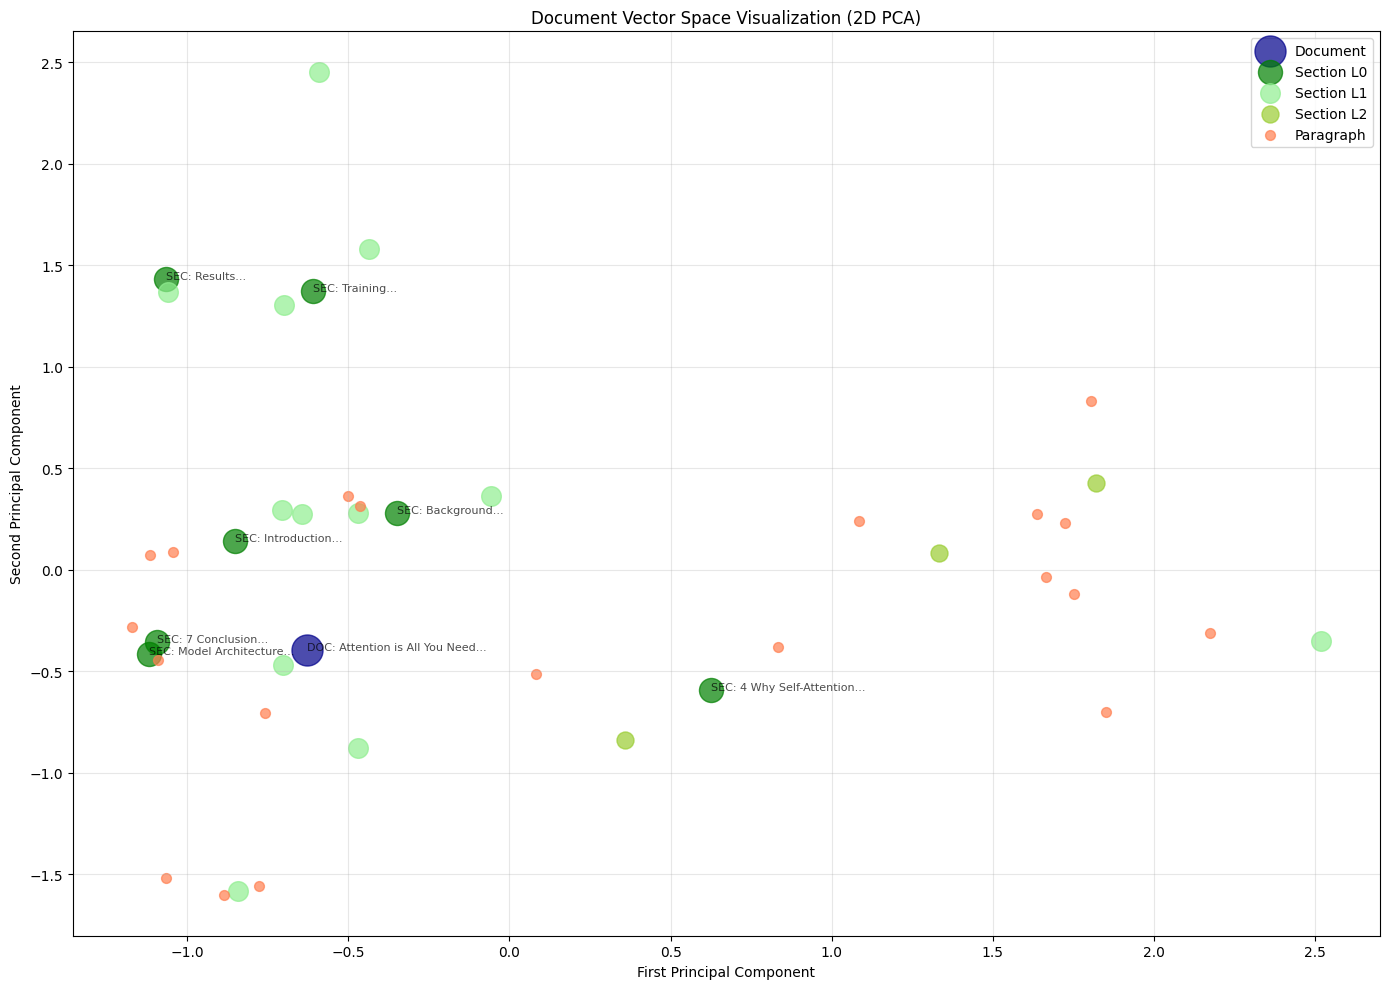

Explained variance ratio: [0.20268025 0.11784332]
Total variance explained: 32.05%


In [ ]:
### STEP 9b: VISUALIZE TEST VECTORS - 2D VISUALIZATIONS

# Create 2D visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D
pca_2d = PCA(n_components=2)
vectors_2d = pca_2d.fit_transform(all_vectors_np)

# Create figure
plt.figure(figsize=(14, 10))

# Define colors and sizes
type_colors = {
    'document': 'darkblue',
    'section_L0': 'green',
    'section_L1': 'lightgreen',
    'section_L2': 'yellowgreen',
    'paragraph': 'coral'
}
type_sizes = {
    'document': 500,
    'section_L0': 300,
    'section_L1': 200,
    'section_L2': 150,
    'paragraph': 50
}

# Plot each type
for t in type_colors.keys():
    mask = [all_types[i] == t for i in range(len(all_types))]
    if any(mask):
        plt.scatter(
            vectors_2d[mask, 0],
            vectors_2d[mask, 1],
            c=type_colors[t],
            s=type_sizes[t],
            alpha=0.7,
            label=t.replace('_', ' ').title()
        )

# Add labels for document and main sections
for i, (label, type_) in enumerate(zip(all_labels, all_types)):
    if type_ in ['document', 'section_L0']:
        plt.annotate(label, 
                    (vectors_2d[i, 0], vectors_2d[i, 1]),
                    fontsize=8,
                    alpha=0.7)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Document Vector Space Visualization (2D PCA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Explained variance ratio: {pca_2d.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca_2d.explained_variance_ratio_):.2%}")

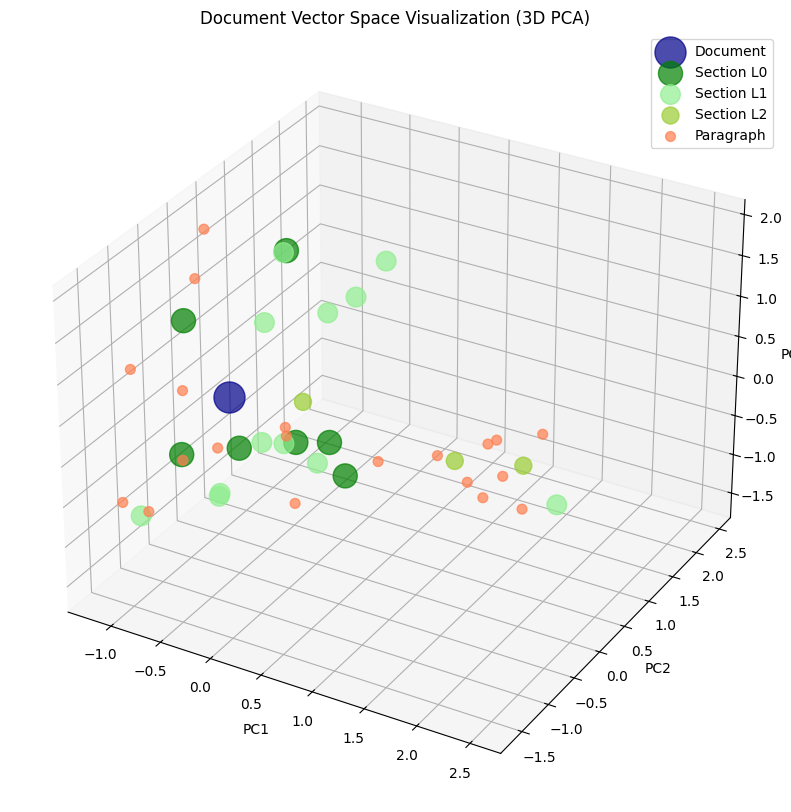

3D Explained variance ratio: [0.20268025 0.11784332 0.0947157 ]
3D Total variance explained: 41.52%


In [ ]:
### STEP 9c: VISUALIZE TEST VECTORS - 3D VISUALIZATION

# Create 3D visualization
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3D
pca_3d = PCA(n_components=3)
vectors_3d = pca_3d.fit_transform(all_vectors_np)

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each type
for t in type_colors.keys():
    mask = [all_types[i] == t for i in range(len(all_types))]
    if any(mask):
        ax.scatter(
            vectors_3d[mask, 0],
            vectors_3d[mask, 1],
            vectors_3d[mask, 2],
            c=type_colors[t],
            s=type_sizes[t],
            alpha=0.7,
            label=t.replace('_', ' ').title()
        )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Document Vector Space Visualization (3D PCA)')
ax.legend()

plt.show()

print(f"3D Explained variance ratio: {pca_3d.explained_variance_ratio_}")
print(f"3D Total variance explained: {sum(pca_3d.explained_variance_ratio_):.2%}")

In [ ]:
### STEP 9d: VISUALIZE TEST VECTORS - SEMANTIC CLUSTERING

# Analyze semantic clustering
print("\n🔍 ANALYZING SEMANTIC CLUSTERING:")
print("=" * 60)

# Find closest vectors to the document vector
doc_vec = vectors['document_vector']['vector']
similarities = cosine_similarity([doc_vec], all_vectors_np)[0]

# Sort by similarity
sorted_indices = np.argsort(similarities)[::-1]

print("\nVectors most similar to the document vector:")
for i in sorted_indices[1:6]:  # Skip first (itself)
    print(f"  {all_labels[i]}: {similarities[i]:.3f}")

# Check if main sections cluster together
print("\nMain section similarities:")
main_sections = [(i, l) for i, (l, t) in enumerate(zip(all_labels, all_types)) if t == 'section_L0']
for i, (idx1, label1) in enumerate(main_sections[:3]):
    for idx2, label2 in main_sections[i+1:i+2]:
        sim = cosine_similarity([all_vectors_np[idx1]], [all_vectors_np[idx2]])[0][0]
        print(f"  {label1} ↔ {label2}: {sim:.3f}")


🔍 ANALYZING SEMANTIC CLUSTERING:

Vectors most similar to the document vector:
  PARA: The dominant sequenc...: 0.950
  SEC: 7 Conclusion...: 0.711
  SEC: Model Architecture...: 0.686
  PARA: Most competitive neu...: 0.676
  PARA: Attention mechanisms...: 0.667

Main section similarities:
  SEC: Introduction... ↔ SEC: Background...: 0.701
  SEC: Background... ↔ SEC: Model Architecture...: 0.565
  SEC: Model Architecture... ↔ SEC: 4 Why Self-Attention...: 0.528
